In [1]:
import warnings
warnings.filterwarnings(action='ignore')
%config Completer.use_jedi = False
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['axes.unicode_minus'] = False
plt.rcParams['font.family'] = 'NanumGothicCoding'
plt.rcParams['font.size'] = 10
import seaborn as sns

import tensorflow as tf
from tensorflow.keras import datasets # tensorflow가 제공하는 데이터 셋을 사용하기 위해 import 한다.
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
# tensorflow에서 합성곱 신경망(Convolution Neural Network, CNN)을 사용하기 위해 추가한다.
from tensorflow.keras.layers import Conv2D # 신경망에 추가할 합성곱 레이어를 생성하기 위해 import 한다.
from tensorflow.keras.layers import MaxPool2D # 신경망에 추가할 맥스 풀링 레이어를 생성하기 위해 import 한다.
from tensorflow.keras.layers import Flatten # 신경망의 최종 출력층에서 벡터 형태를 만들기 위해 import 한다.
from tensorflow.keras.layers import Dropout # 신경망에 추가할 드롭다운 레이어를 생성하기 위해 import 한다.

합성곱 신경망(Convolution Neural Network, CNN)

합성곱 신경망은 흔히 CNN이라고 부르는 방법으로 합성곱이라는 연산을 사용하는 신경망이다. CNN은 실제 여러 분야에서 사용되는 방법으로 특히 이미지 분류 작업에서 좋은 성능을 보여준다.

합성곱 연산은 아래와 같은 연산을 의미한다.

$$y(i) = (x \times w)(i) = \sum_{k=-\infty}^{\infty} x(k)w(i-k)$$

위 식은 i 시점에서의 입력 데이터 x값과 가중치 w값의 합성곱 연산의 결과는 y(i)와 같음을 나타낸다.  
위 수식에서 k도 시점을 의미하는데, 가중치 w의 시점은 w(i)가 아닌 w(i-k)임을 알 수 있다. 이를 플립(flip)이라고 하며 가중치 커널이라고도 부른다. 플립은 우리말로 하면 '뒤집다'라는 뜻으로 가중치의 시점을 뒤집는다는 뜻이다. 위 식은 시점의 순서와 상관없이 결과가 동일하므로 아래와 같이 쓸수도 있다.

$$y(i) = (x \times w)(i) = \sum_{k=-\infty}^{\infty} x(i-k)w(k)$$

패딩(Padding)

패딩은 입력 데이터 주변을 특정 값으로 채우는 것을 말한다.

<img src="./cnn_1.png" width="600"/>

신경망에 커널을 적용하면 층이 깊어질수록 데이터의 차원은 점점 줄어든다. 5 * 5 차원의 입력 데이터에 2 * 2 차원의 커널을 합성곱했을 때 출력 데이터의 4 * 4 차원으로 입력 데이터보다 출력 데이터의 차원이 줄어든다. 이렇듯, 입력 데이터에 커널을 합성곱한 후 출력 데이터의 차원이 줄어드는 현상을 방지하기 위해서 패딩이라는 방법을 사용한다.

스트라이드(Stride)

스트라이드는 한 번 합성곱 연산을 한 후 다음 계산 영역을 선택할 때 얼마나 이동할지 간격을 정하는 것이다.

<img src="./cnn_2.png" width="400"/>

스트라이드 2를 적용한 후 합성곱 연산을 한 결과 스트라이드 1때와 비교해 보면 출력 데이터의 차원이 더 적은 것을 알 수 있다.

풀링(Pooling)

풀링은 데이터의 차원을 줄이는 방법이다.

<img src="./cnn_3.png" width="250"/>

맥스 풀링이란 해당 영역에서 가장 큰 값을 선택하는 방법이다.

합성곱 신경망을 이용해서 손글씨 인식 모델을 생성해본다.

In [2]:
# 일관된 결과값이 나오도록 numpy와 tensorflow의 seed를 설정한다.
np.random.seed(0)
tf.random.set_seed(0)

합성곱 신경망에 사용할 데이터 준비

In [3]:
# mnist 손글씨 데이터는 학습 데이터와 테스트 데이터가 튜플로 구분되서 저장되어 있다.
# mnist.load_data() 메소드는 (학습 피쳐 데이터, 학습 레이블 데이터)와 (테스트 피쳐 데이터, 테스트 레이블 데이터)를
# 튜플 형태로 묶어서 리턴한다.
# 손글씨 데이터 셋을 학습 데이터와 테스트 데이터로 저장한다.
(x_train, y_train), (x_test, y_test) = datasets.mnist.load_data()

# 오리지널 데이터 확인
# 학습 피쳐 데이터의 차원을 확인하면 (이미지 개수, 행, 열) 형태로 나온다.
# 즉, 학습 피쳐 데이터는 28행 * 28열의 이미지 60,000개로 구성된 행렬이라는 것을 알 수 있다.
print(type(x_train), x_train.shape)
print(type(y_train), y_train.shape) # 학습 레이블 데이터는 스칼라값 60,000개로 이루어진 벡터이다.
print(type(x_test), x_test.shape) # 테스트 피쳐 데이터는 28행 * 28열의 이미지 10,000개로 구성된 행렬이라는 것을 알 수 있다.
print(type(y_test), y_test.shape) # 테스트 레이블 데이터는 스칼라값 10,000개로 이루어진 벡터이다.

<class 'numpy.ndarray'> (60000, 28, 28)
<class 'numpy.ndarray'> (60000,)
<class 'numpy.ndarray'> (10000, 28, 28)
<class 'numpy.ndarray'> (10000,)


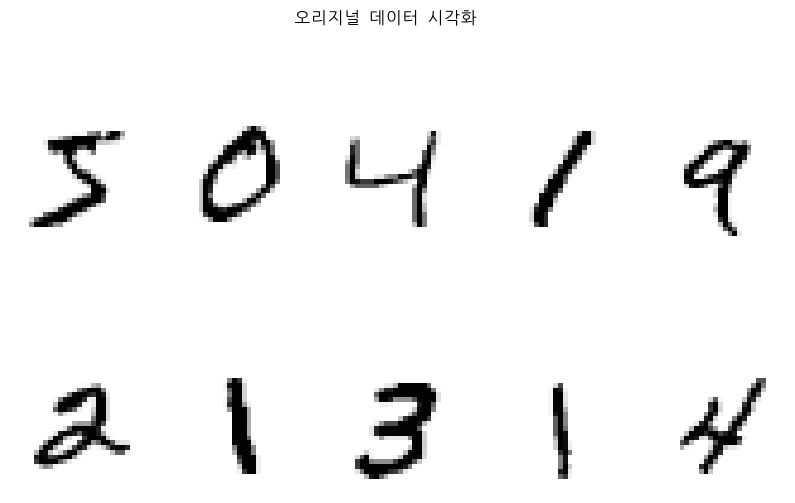

[5 0 4 1 9 2 1 3 1 4]


In [4]:
# 오리지널 데이터 시각화
plt.figure(figsize=(10, 6))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    plt.imshow(x_train[i], cmap='Greys')
    plt.axis('off')
plt.suptitle('오리지널 데이터 시각화')
plt.show()
print(y_train[:10])

In [5]:
# 레이블 종류 확인
# 레이블의 종류를 확인함으로써 분류 문제인지 아니면 회귀 문제인지 파악할 수 있고, 
# 분류 문제라면 몇 가지 클래스로 구분되는 지 알 수 있다.
print(set(y_train))
n_class = len(set(y_train))
print(n_class)

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9}
10


In [6]:
# 피쳐 데이터 차원 변경
# 오리지널 데이터의 차원은 (이미지 개수, 행, 열) 형태의 3차원 형태로 표현되어 있지만 합성곱 신경망은 
# 입력 데이터를 (이미지 개수, 행, 열, 채널 개수) 형태의 4차원 형태로 구성해야 한다.
# 이때, 채널이란 흔히 RGB로 구분되는 것을 의미하는데, 만약 하나의 이미지 데이터를 R을 이용한 픽셀값,
# G를 이용한 픽셀값, B를 이용한 픽셀값으로 나타낼 때, 채널 개수는 3개가 된다.
# 하지만 tensorflow가 제공하는 mnist 손글씨 데이터는 흑백 이미지이므로 채널 개수는 1개가 된다.
# 합성곱 신경망에 사용할 이미지 데이터는 reshape() 메소드를 이용해서 (이미지 개수, 행, 열, 채널 개수)
# 형태로 변형해서 사용한다.
x_train = x_train.reshape(60000, 28, 28, 1) # x_train.reshape(-1, 28, 28, 1)
x_test = x_test.reshape(10000, 28, 28, 1) # x_test.reshape(-1, 28, 28, 1)
print(x_train.shape, x_test.shape)

# 피쳐 데이터 스케일 조정
# 이미지의 픽셀값은 0에서 255 사이에 있으므로 최소값이 0, 최대값이 1이 되도록 조정한다.
# '/=' 대입 연산자를 사용했을 때 에러가 발생되면 '/' 연산을 사용한다.
x_train = x_train / 255
x_test = x_test / 255

(60000, 28, 28, 1) (10000, 28, 28, 1)


In [7]:
# 레이블 데이터 원-핫 인코딩
# to_categorical() 메소드는 원-핫 인코딩을 실행한다.
print(y_train[0], y_test[0])
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)
print(y_train[0], y_test[0])

5 7
[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.] [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]


합성곱 신경망 모델을 만든다.

In [8]:
# Sequential 객체 선언 후 Sequential 모델에 add() 메소드로 레이어를 추가해서 신경망을 만든다.
model = Sequential() # 시퀀스를 사용하는 신경망 모델을 만든다.

# 입력 레이어를 만든다.
# 입력 레이어는 input_dim 또는 input_shape 속성으로 신경망에 입력되는 데이터의 모양(차원)을 지정해야 한다.
# input_dim 속성은 입력 데이터가 벡터(1차원)일 경우 사용하며 벡터를 구성하는 스칼라 값의 개수를 지정한다.
# input_shape 속성은 입력 데이터가 행렬(2차원)일 경우
# filters 속성으로 레이어의 출력 차원을 지정한다. 레이어를 구성하는 노드의 개수를 지정한다.
# kernel_size 속성으로 커널의 크기를 지정한다.
# padding 속성으로 패딩 여부를 지정한다. 기본값은 'valid'로 패딩을 적용하지 않고 'same'은 패딩을 적용한다.
# activation 속성으로 활성화 함수를 지정한다.
# Conv2D 레이어의 Output Shape은 padding을 적용하지 않으면 [입력 데이터의 차원 + 1 - 커널의 차원]로
# 결정되고 padding을 적용하면 입력 차원과 같다.
# padding='valid'일 경우 [입력 데이터의 차원(28) + 1 - 커널의 차원(5)] = 28 + 1 - 5 = 24(None, 24, 24, 64),
# padding='same'일 경우 (None, 28, 28, 64)가 된다.
# Conv2D 레이어의 Param은 [커널의 크기 * 입력 채널 크기 * 필터 크기 + 필터마다 1개의 바이어스]로 결정된다.
# 커널의 크기(5 * 5) * 입력 채널 크기(1) * 필터 크기(64) + 필터마다 1개의 바이어스(64) = 25 * 1 * 64 + 64 = 1664
model.add(Conv2D(input_shape=(28, 28, 1), filters=64, kernel_size=(5, 5), padding='valid', activation='relu'))
# 입력 레이어에 맥스 풀링 레이어를 추가한다.
# pool_size 속성으로 맥스 풀링을 실행할 픽셀의 크기를 지정한다. 기본값은 (2, 2)이다.
# MaxPool2D 레이어의 Output Shape은 [입력 데이터의 차원 / pool_size의 차원]로 결정된다.
# [입력 데이터의 차원(24) / pool_size의 차원(2)] = 24 / 2 = 12(None, 12, 12, 64)
# MaxPool2D 레이어의 Param은 없으므로 0이다.
model.add(MaxPool2D(pool_size=(2, 2)))
# 입력 레이어에 드롭아웃 레이어를 추가한다.
# rate 속성으로 드롭아웃(사용하지 않을)할 노드의 비율을 지정한다.
# Dropout 레이어의 Output Shape 입력 shape과 같다. (None, 12, 12, 64)
# Dropout 레이어의 Param은 없으므로 0이다.
model.add(Dropout(rate=0.25))

# 히든 레이어를 만든다.
# 입력 레이어를 제외한 현재 레이어의 입력은 이전 레이어의 출력이므로 input_shape 속성을 사용할 필요가 없다.
# Output Shape은 padding='valid'이므로 [입력 데이터의 차원(12) + 1 - 커널의 차원(3)] = 12 + 1 - 3(None, 10, 10, 32)
# Param은 커널의 크기(3 * 3) * 입력 채널 크기(64) * 필터 크기(32) + 필터마다 1개의 바이어스(32) = 9 * 64 * 32 + 32 = 18464 
model.add(Conv2D(filters=32, kernel_size=(3, 3), padding='valid', activation='relu'))
# 히든 레이어에 맥스 풀링 레이어를 추가한다.
# Output Shape은 [입력 데이터의 차원(10) / pool_size의 차원(2)] = 10 / 2 = 5(None, 5, 5, 32)
# MaxPool2D 레이어의 Param은 없으므로 0이다.
model.add(MaxPool2D(pool_size=(2, 2)))
# 히든 레이어에 드롭아웃 레이어를 추가한다.
# Dropout 레이어의 Output Shape 입력 shape과 같다. (None, 5, 5, 32)
# Dropout 레이어의 Param은 없으므로 0이다.
model.add(Dropout(rate=0.25))

# 출력 레이어를 만든다.
# 출력 레이어에 Flatten 레이어를 추가한다.
# Flatten 레이어는 신경망의 출력 레이어에서 소프트맥스 활성화 함수를 사용하기 위해 벡터 형태로 펼쳐준다.
# => 1차원으로 만든다.
# Flatten 레이어의 Output Shape은 (5, 5, 32)를 1차원으로 변경하면 되므로 다 곱하면 된다. 5 * 5 * 32 = 800(None, 800)
# Flatten 레이어의 Param은 없으므로 0이다.
model.add(Flatten())
# 출력 레이어는 Dense 레이어로 구성하므로 출력 레이어에 Dense 레이어를 추가한다.
# Dense 레이어는 input_dim 속성으로 입력 데이터 1건(피쳐)의 차원, units 속성으로 레이어의 출력 차원,
# activation 속성으로 활성화 함수를 지정한다.
# 입력 레이어를 제외한 현재 레이어의 입력은 이전 레이어의 출력이므로 input_dim 속성을 사용할 필요가 없다.
# Dense 레이어의 Output Shape은 units 속성의 크기로 결정된다. (None, 1024)
# Dense 레이어의 Param은 [(입력 채널 크기 + 바이어스) * 출력 차원 크기]로 계산되고 바이어스는 layer당 1개 이다.
# (입력 채널 크기(800) + 바이어스(1)) * 출력 차원 크기(1024) = (800 + 1) * 1024 = 820224
model.add(Dense(units=1024, activation='relu'))
# 출력 레이어에 드롭아웃 레이어를 추가한다.
# Dropout 레이어의 Output Shape 입력 shape과 같다. (None, 1024)
# Dropout 레이어의 Param은 없으므로 0이다.
model.add(Dropout(rate=0.5))
# 최종 출력에 사용할 최종 출력할 클래스 개수를 지정하는 소프트맥스 활성화 함수를 사용하는 Dense 레이어를 추가한다.
# Dense 레이어의 Output Shape은 units 속성의 크기로 결정된다. (None, 10)
# Dense 레이어의 Param은 [(입력 채널 크기 + 바이어스) * 출력 차원 크기]로 계산되고 바이어스는 layer당 1개 이다.
# (입력 채널 크기(1024) + 바이어스(1)) * 출력 차원 크기(10) = (1024 + 1) * 10 = 10250
model.add(Dense(units=n_class, activation='softmax'))

model.summary() # 신경망 모델의 구조를 확인한다.

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 24, 24, 64)        1664      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 12, 12, 64)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 12, 12, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 10, 10, 32)        18464     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 5, 5, 32)         0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 5, 5, 32)          0

합성곱 신경망 모델 컴파일

In [9]:
# compile() 메소드로 생성한 신경망 모델을 컴파일 한다.
# 분류 신경망은 loss 속성에 손실(비용, 오차) 함수를 지정할 때 이진 분류일 경우 'binary_crossentropy'를
# 지정하고, 3개 이상의 클래스로 분류할 경우 'categorical_crossentropy'를 지정한다.
# optimizer 속성에 최적화 함수(일반적으로 adam)를 지정한다.
# metrics 속성에 평가 기준을 지정한다.
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

합성곱 신경망 모델 학습

In [10]:
# fit() 메소드의 인수로 학습 데이터와 원-핫 인코딩된 학습 데이터에 따른 레이블 및 epochs 속성에 학습 횟수,
# batch_size 속성에 미니 배치 크기를 넘겨서 컴파일된 신경망 모델을 학습시킨다.
history = model.fit(x_train, y_train, epochs=10, batch_size=100)

Epoch 1/10
600/600 [==============================] - 48s 79ms/step - loss: 0.2118 - accuracy: 0.9340
Epoch 2/10
600/600 [==============================] - 47s 78ms/step - loss: 0.0710 - accuracy: 0.9774
Epoch 3/10
600/600 [==============================] - 46s 77ms/step - loss: 0.0506 - accuracy: 0.9846
Epoch 4/10
600/600 [==============================] - 46s 77ms/step - loss: 0.0441 - accuracy: 0.9860
Epoch 5/10
600/600 [==============================] - 46s 76ms/step - loss: 0.0394 - accuracy: 0.9875
Epoch 6/10
600/600 [==============================] - 46s 76ms/step - loss: 0.0340 - accuracy: 0.9894
Epoch 7/10
600/600 [==============================] - 47s 78ms/step - loss: 0.0324 - accuracy: 0.9894
Epoch 8/10
600/600 [==============================] - 46s 77ms/step - loss: 0.0291 - accuracy: 0.9910
Epoch 9/10
600/600 [==============================] - 46s 77ms/step - loss: 0.0274 - accuracy: 0.9912
Epoch 10/10
600/600 [==============================] - 46s 76ms/step - loss: 0.024

In [11]:
# evaluate() 메소드로 테스트 데이터와 원-핫 인코딩된 테스트 데이터에 따른 레이블을 넘겨서
# 학습된 신경망을 평가한다.
print(model.evaluate(x_train, y_train)) # 학습 데이터와 학습 데이터에 따른 레이블 학습 평가
print(model.evaluate(x_test, y_test)) # 테스트 데이터와 테스트 데이터에 따른 레이블 학습 평가

1875/1875 [==============================] - 14s 7ms/step - loss: 0.0070 - accuracy: 0.9980
[0.006972864735871553, 0.9980499744415283]
313/313 [==============================] - 2s 7ms/step - loss: 0.0192 - accuracy: 0.9942
[0.019217532128095627, 0.9941999912261963]


합성곱 신경망 모델 예측

In [12]:
# predict() 메소드로 테스트 피쳐 데이터를 넘겨서 예측값을 계산한다.
predict = model.predict(x_test)
# 넘파이의 argmax() 메소드는 인수로 지정된 값 중에 가장 큰 값의 인덱스를 리턴하기 때문에
# 원-핫 인코딩된 값을 원래 숫자로 바꿀 수 있다.
print(y_test[0], np.argmax(y_test[0]))
print(predict[0], np.argmax(predict[0]))

313/313 [==============================] - 2s 7ms/step
[0. 0. 0. 0. 0. 0. 0. 1. 0. 0.] 7
[1.7487085e-12 7.2790801e-11 4.7262505e-09 1.9718258e-09 9.4923025e-10
 1.6648288e-10 1.4759159e-14 9.9999994e-01 3.8083461e-10 9.4253387e-09] 7


잘못 예측한 데이터 확인

In [13]:
y_test = np.argmax(y_test, axis=1)
print(y_test, set(y_test))
predict = np.argmax(predict, axis=1)
print(predict, set(predict))

[7 2 1 ... 4 5 6] {0, 1, 2, 3, 4, 5, 6, 7, 8, 9}
[7 2 1 ... 4 5 6] {0, 1, 2, 3, 4, 5, 6, 7, 8, 9}


In [14]:
# 오답 데이터의 인덱스를 리스트에 저장한다.
diff_index = []
for i in range(len(y_test)):
    if y_test[i] != predict[i]:
        diff_index.append(i)
print(len(diff_index))
print(diff_index)

58
[445, 646, 659, 716, 947, 1014, 1226, 1232, 1242, 1260, 1319, 1393, 1527, 1621, 1709, 1901, 1903, 1987, 2035, 2118, 2130, 2135, 2597, 2654, 2896, 2927, 2939, 3073, 3225, 3422, 3475, 3520, 3558, 3808, 3941, 4176, 4369, 4740, 4807, 4823, 4860, 4956, 5265, 5937, 6559, 6576, 6597, 6625, 6651, 6783, 8408, 8527, 9009, 9015, 9642, 9664, 9692, 9729]


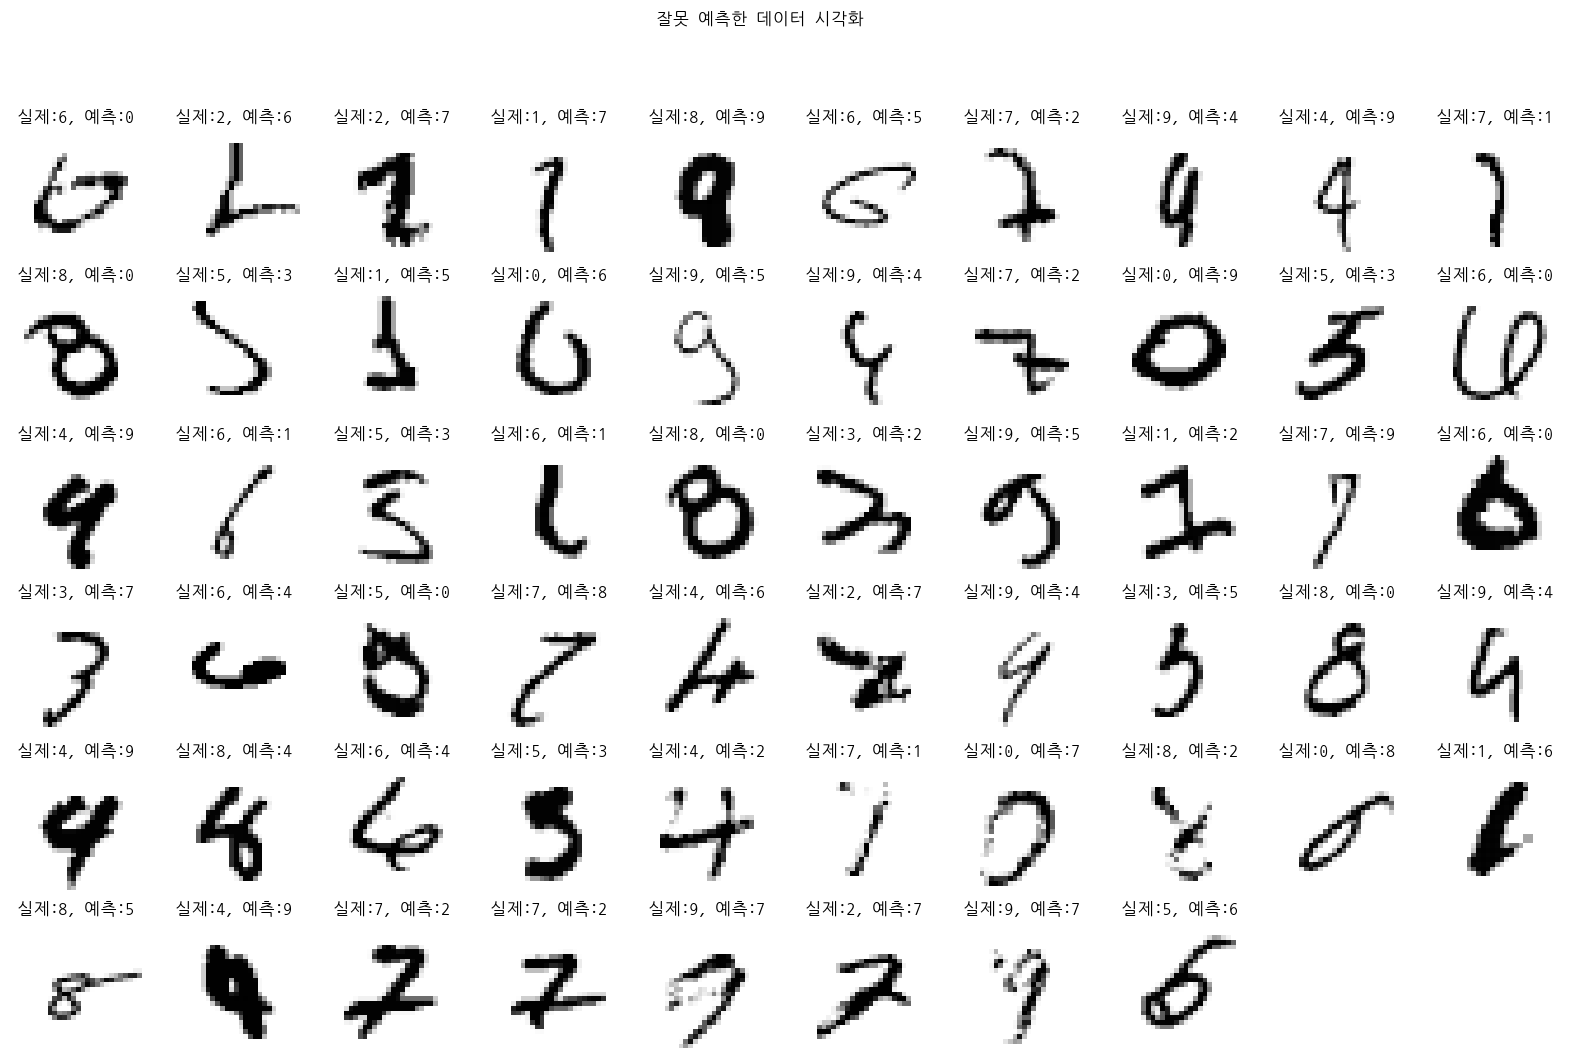

In [15]:
# 잘못 예측한 데이터 시각화
plt.figure(figsize=(20, 12))
for i in range(len(diff_index)):
    plt.subplot(6, 10, i + 1)
    plt.imshow(x_test[diff_index[i]], cmap='Greys')
    plt.title('실제:' + str(y_test[diff_index[i]]) + ', 예측:' + str(predict[diff_index[i]]))
    plt.axis('off')
plt.suptitle('잘못 예측한 데이터 시각화')
plt.show()

모델 저장 및 불러오기

In [16]:
# 모델 저장은 save() 메소드를 사용해서 'h5' 파일로 저장한다.
# 'h5'는 'hdf5' 파일을 의미하고 'Hierarchical Data Format Version 5'의 줄인말로 대용량 데이터를
# 저장하기 위한 파일 포맷이다.
model.save('./data/cnn_model.h5')

In [17]:
# 'h5' 파일 불러오기
from tensorflow.keras.models import load_model
ann_model = load_model('./data/cnn_model.h5')
ann_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 24, 24, 64)        1664      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 12, 12, 64)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 12, 12, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 10, 10, 32)        18464     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 5, 5, 32)         0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 5, 5, 32)          0